АВТ-213 Гомзякова Софья

# Лабораторная работа №2

## Введение

### Цель работы

Исследование методов анализа ассоциативных правил.

### Постановка задачи

В файле "ass_rules.pdf" находится программный код для выполнения данной работы. Провести исследование методов анализа ассоциативных правил на датасете с Kaggle:
1. Загрузить датасет из репозитория (например, kaggle.com или аналогичных платформ). Данные должны представлять собой информацию о купленных вместе товарах.
2. Привести описание данных из датасета: график вывода длин транзакций, список уникальных товаров и др. 
3. Алгоритм Apriori: выполнить анализ ассоциативных правил при помощи алгоритма Apriori с изначальными условиями в соответствии с вариантом задания. Проанализировать полученные результаты, выделив полезные и тривиальные правила, и оценив значение достоверности, лифта правил. Провести оценку влияния параметров алгоритма на получаемые правила (на количество правил и метрики).
4. Алгоритм FPG: провести анализ правил, используя алгоритм FPG. В отчете привести правила, получившиеся в результате использования данного алгоритма.
5. Алгоритмически определить минимальные значения поддержки для составления правил из 1, 2, и т.д. объектов в одном из алгоритмов.
6. Последовательно меняя параметры (значения поддержки и достоверности) одного из алгоритмов получить наборы ассоциативных правил. Сделать выводы на основе проведенных экспериментов.
7. Проанализировать получающийся в результате работы программы граф. Объяснить, какую информацию можно из него извлечь.
8. Предложить и реализовать свой способ визуализации ассоциативных правил и метрик.

## Импорт библиотек

In [415]:
from kagglehub import dataset_download

import pandas as pd

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import networkx as nx

## Загрузка датасета

In [416]:
# dspath = dataset_download("d4rklucif3r/market-basket-optimisation", 'Market_Basket_Optimisation.csv')
dspath = 'Market_Basket_Optimisation.csv'

print('Набор данных:')
all_data = pd.read_csv(dspath)
print(all_data.info())

Набор данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   shrimp             7500 non-null   object 
 1   almonds            5746 non-null   object 
 2   avocado            4388 non-null   object 
 3   vegetables mix     3344 non-null   object 
 4   green grapes       2528 non-null   object 
 5   whole weat flour   1863 non-null   object 
 6   yams               1368 non-null   object 
 7   cottage cheese     980 non-null    object 
 8   energy drink       653 non-null    object 
 9   tomato juice       394 non-null    object 
 10  low fat yogurt     255 non-null    object 
 11  green tea          153 non-null    object 
 12  honey              86 non-null     object 
 13  salad              46 non-null     object 
 14  mineral water      24 non-null     object 
 15  salmon             7 non-null      object 
 16  antioxydan

### Анализ транзакций

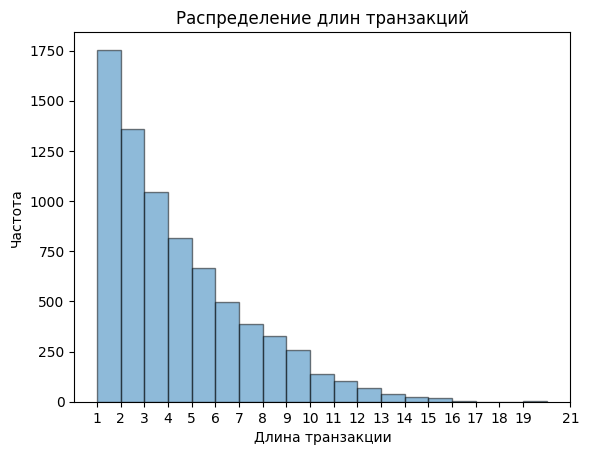

In [417]:
transaction_lengths = all_data.notnull().sum(axis=1)
max_transaction_len = max(transaction_lengths)
plt.hist(transaction_lengths, bins=range(1, max_transaction_len + 2), edgecolor='black', alpha=0.5)
plt.xlabel('Длина транзакции')
x = np.linspace(1, max_transaction_len + 2, max_transaction_len + 1, dtype=int)
plt.xticks(x)
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.show()

На гистограмме распределения длин транзакций мы можем наблюдать, что наиболее часто встречающаяся длина транзакции - 1 товар, а максимальная длина транзакции - 19 товаров.

### Очистка данных

In [418]:
np_data = all_data.to_numpy()
np_data = [[elem for elem in row if isinstance(elem,str)] for row in np_data]

print('Очищенные данные из датасета:')
display(np_data)

Очищенные данные из датасета:


[['burgers', 'meatballs', 'eggs'],
 ['chutney'],
 ['turkey', 'avocado'],
 ['mineral water', 'milk', 'energy bar', 'whole wheat rice', 'green tea'],
 ['low fat yogurt'],
 ['whole wheat pasta', 'french fries'],
 ['soup', 'light cream', 'shallot'],
 ['frozen vegetables', 'spaghetti', 'green tea'],
 ['french fries'],
 ['eggs', 'pet food'],
 ['cookies'],
 ['turkey', 'burgers', 'mineral water', 'eggs', 'cooking oil'],
 ['spaghetti', 'champagne', 'cookies'],
 ['mineral water', 'salmon'],
 ['mineral water'],
 ['shrimp',
  'chocolate',
  'chicken',
  'honey',
  'oil',
  'cooking oil',
  'low fat yogurt'],
 ['turkey', 'eggs'],
 ['turkey',
  'fresh tuna',
  'tomatoes',
  'spaghetti',
  'mineral water',
  'black tea',
  'salmon',
  'eggs',
  'chicken',
  'extra dark chocolate'],
 ['meatballs', 'milk', 'honey', 'french fries', 'protein bar'],
 ['red wine', 'shrimp', 'pasta', 'pepper', 'eggs', 'chocolate', 'shampoo'],
 ['rice', 'sparkling water'],
 ['spaghetti', 'mineral water', 'ham', 'body spray',

### Список уникальных товаров

In [419]:
unique_items = set()
for row in np_data:
    for elem in row:
        unique_items.add(elem)
print(f'Уникальные товары (количество {len(unique_items)}):')
print(unique_items)

Уникальные товары (количество 120):
{'honey', 'salmon', 'babies food', 'mashed potato', 'milk', 'energy drink', 'mint green tea', 'melons', 'protein bar', 'soda', 'mushroom cream sauce', 'soup', 'light cream', ' asparagus', 'spinach', 'pancakes', 'vegetables mix', 'chicken', 'whole weat flour', 'oil', 'water spray', 'white wine', 'tea', 'dessert wine', 'frozen smoothie', 'cauliflower', 'gluten free bar', 'hot dogs', 'shallot', 'pasta', 'extra dark chocolate', 'chili', 'toothpaste', 'fresh bread', 'corn', 'clothes accessories', 'antioxydant juice', 'mineral water', 'grated cheese', 'shrimp', 'asparagus', 'nonfat milk', 'brownies', 'ham', 'burgers', 'french fries', 'cooking oil', 'shampoo', 'napkins', 'yams', 'cookies', 'spaghetti', 'turkey', 'almonds', 'barbecue sauce', 'yogurt cake', 'pet food', 'tomatoes', 'cake', 'chutney', 'pepper', 'zucchini', 'strong cheese', 'light mayo', 'frozen vegetables', 'sparkling water', 'strawberries', 'flax seed', 'mint', 'chocolate bread', 'french wine'

### One-Hot Encoding для представления транзакций в виде k-itemset

In [420]:
te = TransactionEncoder()
te_ary = te.fit(np_data).transform(np_data)
data = pd.DataFrame(te_ary, columns=te.columns_)
print(data.head())

    asparagus  almonds  antioxydant juice  asparagus  avocado  babies food  \
0       False    False              False      False    False        False   
1       False    False              False      False    False        False   
2       False    False              False      False     True        False   
3       False    False              False      False    False        False   
4       False    False              False      False    False        False   

   bacon  barbecue sauce  black tea  blueberries  ...  turkey  vegetables mix  \
0  False           False      False        False  ...   False           False   
1  False           False      False        False  ...   False           False   
2  False           False      False        False  ...    True           False   
3  False           False      False        False  ...   False           False   
4  False           False      False        False  ...   False           False   

   water spray  white wine  whole weat flour

## Алгоритм FP-Growth

Суть алгоритма Frequent Pattern-Growth состоит в построении дерева популярных предметных наборов (FP-дерева).

1. Построение FP-дерева:

1.1. Производится сканирование исходного набора данных и выделяется множество часто встречающихся наборов элементов, то есть наборов, у которых поддержка больше или равна минимальной.

1.2. Строится FP-дерево, в котором наборы элементов будут упорядочиваться по убыванию значений их поддержки по правилу: если в дереве встречается одноименный с элементом узел, то новый узел не создается, а индекс соответствующего узла увеличивается на единицу; иначе - создается новый узел с индексом 1.

2. Извлечение часто встречающихся наборов предметов:

2.1. Выбирается какой-либо элемент из исходного набора, и находятся все возможные пути, которые ведут к узлам этого элемента. Далее производим подсчет для каждого пути, сколько раз этот элемент встречается в нем.

2.2. Удаляется сам элемент (суффикс набора) из ведущих к нему путей. Производится подсчет совпадений элементов в префиксах путей и расположение их в порядке убывания, благодаря чему образуется новая совокупность наборов.

2.3. На основе этого элемента строится новое, условное FP-дерево - оно связано с этим объектом.

2.4. В этом FP-дереве присутствуют все узлы с достаточной поддержкой. Индексы узла суммируются, если элемент встречается с частотой, большей 2.

2.5. Начиная с вершины, фиксируются пути до узлов, поддержка который больше или равна заданной. Элемент, удаленный на шаге 2.2, возвращается назад, и рассчитывается результирующее значение поддержки.

In [421]:
#Алгоритм FPG
df1 = fpgrowth(data, min_support=0.02, use_colnames = True)
print('FPG')
df1 = df1.sort_values(by='support', ascending=False)
print(df1)

FPG
      support                           itemsets
5    0.238267                    (mineral water)
0    0.179733                             (eggs)
14   0.174133                        (spaghetti)
11   0.170933                     (french fries)
20   0.163867                        (chocolate)
..        ...                                ...
68   0.020133  (whole wheat rice, mineral water)
81   0.020133       (mineral water, cooking oil)
93   0.020133           (pancakes, french fries)
100  0.020133   (frozen smoothie, mineral water)
99   0.020000                (eggs, ground beef)

[104 rows x 2 columns]


По результатам алгоритма FPG было получено, что наиболее популярными товарами оказались mineral water с поддержкой 0.238267, eggs с поддержкой 0.179733 и spaghetti с поддержкой 0.174133. Это значит, что, например, mineral water входит в $\approx 23.83 \% $ всех транзакций.

In [422]:
rules = association_rules(df1, metric = "confidence", min_threshold = 0.25)
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))
df1['itemsets'] = df1['itemsets'].apply(lambda x: ', '.join(list(x)))
print(f'\nАссоциативные правила по уровню поддержки (всего найдено {len(rules)}, выведено топ-10)')
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


Ассоциативные правила по уровню поддержки (всего найдено 28, выведено топ-10)
         antecedents    consequents   support  confidence      lift
0          spaghetti  mineral water  0.059733    0.343032  1.439698
1      mineral water      spaghetti  0.059733    0.250699  1.439698
2          chocolate  mineral water  0.052667    0.321400  1.348907
3               eggs  mineral water  0.050933    0.283383  1.189351
4               milk  mineral water  0.048000    0.370370  1.554436
5        ground beef  mineral water  0.040933    0.416554  1.748266
6        ground beef      spaghetti  0.039200    0.398915  2.290857
7  frozen vegetables  mineral water  0.035733    0.374825  1.573133
8               milk      spaghetti  0.035467    0.273663  1.571569
9           pancakes  mineral water  0.033733    0.354839  1.489250


Из полученных ассоциативных правил наибольшей поддержкой обладает правило spaghetti->mineral water с поддержкой 0.059733, достоверностью 0.343032 и лифтом 1.439698 и обратно правило mineral water->spaghetti с той же поддержкой, достоверностью 0.250699 и тем же лифтом.

Это значит, что:
- сочетание spaghetti и mineral water входит в $ \approx 5.97 \% $ всех транзакций,
- при этом при покупке spaghetti покупатель возьмет mineral water с вероятностью 0.343032, а при покупке mineral water возьмет spaghetti с вероятностью 0.250699,
- само правило на 44% значимее, чем если бы товары брали вместе по случайности

## Алгоритм Apriopri

Алгоритм Apriori базируется на утверждении, что если X - подмножество Y, то поддержка X не меньше поддержки Y:

$ X \subseteq Y => supp(X) \leq supp(Y) $

Следствия:
1. Если Y встречается часто, то и любое его подмножество X встречается часто
2. Если X встречается редко, то и любое его супермножество Y встречается редко

Алгоритм:
1. Для каждого товара из набора транзакций вычисляется поддержка, удаляются те товары и содержащие их транзакции, поддержка которых меньше пороговой, получаем множество частых наборов длиной 1 (k=1).
2. Для результатов предыдущего шага $ C_k $ генерируются кандидаты $ C_{k+1} $ - наборы с длиной, большей на 1 (k + 1), включающие в себя объединенные объекты с одинаковыми префиксами длины k-1 (например, для объектов ABC и ABD будет кандидат ABCD).
3. Из списка кандидатов удаляются те, у которых хотя бы одно подмножество длины k-1 не является частым
4. Алгоритм проходит по таблице транзакций, подсчитывая частоту для каждого кандидата
5. Из списка кандидатов удаляются те, у которых поддержка менее порогового значения
6. Возврат на шаг 2, пока в $ C_k $ не останется только один набор
7. Вывод результата

In [423]:
#Алгоритм Apriori
df1 = apriori(data, min_support=0.02, use_colnames = True)
print('Apriori:')
df1 = df1.sort_values(by='support', ascending=False)
print(df1)

Apriori:
     support                           itemsets
34  0.238267                    (mineral water)
13  0.179733                             (eggs)
44  0.174133                        (spaghetti)
17  0.170933                     (french fries)
9   0.163867                        (chocolate)
..       ...                                ...
67  0.020133       (mineral water, cooking oil)
81  0.020133   (frozen smoothie, mineral water)
79  0.020133           (pancakes, french fries)
99  0.020133  (whole wheat rice, mineral water)
71  0.020000                (eggs, ground beef)

[104 rows x 2 columns]


Результаты работы алгоритма Apriori аналогичны результатам алгоритма FPG: самыми популярными товарами оказались mineral water, eggs и spaghetti с поддержкой 0.238267, 0.179733 и 0.174133 соответственно.

In [424]:
rules = association_rules(df1, metric = "confidence", min_threshold = 0.25)
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))
df1['itemsets'] = df1['itemsets'].apply(lambda x: ', '.join(list(x)))
print(f'\nАссоциативные правила по уровню поддержки (всего найдено {len(rules)}, выведено топ-10)')
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


Ассоциативные правила по уровню поддержки (всего найдено 28, выведено топ-10)
         antecedents    consequents   support  confidence      lift
0          spaghetti  mineral water  0.059733    0.343032  1.439698
1      mineral water      spaghetti  0.059733    0.250699  1.439698
2          chocolate  mineral water  0.052667    0.321400  1.348907
3               eggs  mineral water  0.050933    0.283383  1.189351
4               milk  mineral water  0.048000    0.370370  1.554436
5        ground beef  mineral water  0.040933    0.416554  1.748266
6        ground beef      spaghetti  0.039200    0.398915  2.290857
7  frozen vegetables  mineral water  0.035733    0.374825  1.573133
8               milk      spaghetti  0.035467    0.273663  1.571569
9           pancakes  mineral water  0.033733    0.354839  1.489250


Как и в случае алгоритма FPG, из полученных ассоциативных правил наибольшей поддержкой обладает правило spaghetti->mineral water с поддержкой 0.059733, достоверностью 0.343032 и лифтом 1.439698.

     support           itemsets
34  0.238267      mineral water
13  0.179733               eggs
44  0.174133          spaghetti
17  0.170933       french fries
9   0.163867          chocolate
24  0.132000          green tea
33  0.129600               milk
25  0.098267        ground beef
22  0.095333  frozen vegetables
38  0.095067           pancakes


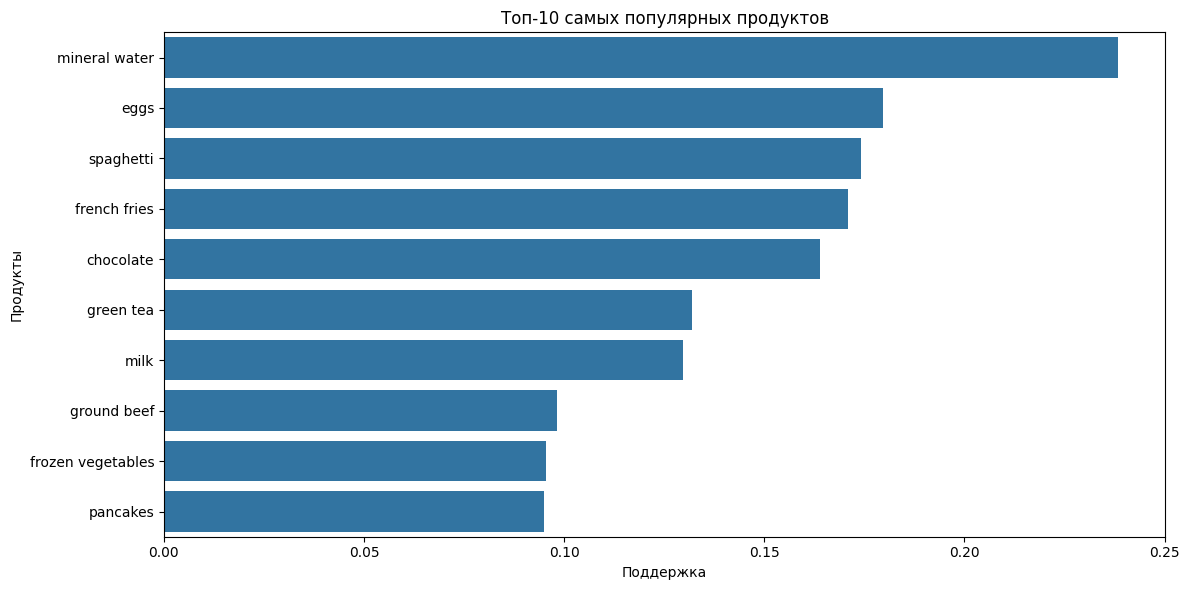

In [425]:
#Поддержка
top_products = df1.head(10)
print(top_products)
plt.figure(figsize=(12, 6))
sns.barplot(x='support', y='itemsets', data=top_products)
plt.title('Топ-10 самых популярных продуктов')
plt.xlabel('Поддержка')
plt.ylabel('Продукты')
plt.tight_layout()
plt.show()

In [426]:
#График достоверности используемых правил
rules = rules.sort_values(by='confidence', ascending=False)
products_1 = rules["antecedents"].tolist()
products_2 = rules["consequents"].tolist()
confidence = rules["confidence"].tolist()
rules_labels = [f"{product1} -> {product2}" for product1, product2 in zip(products_1, products_2)]

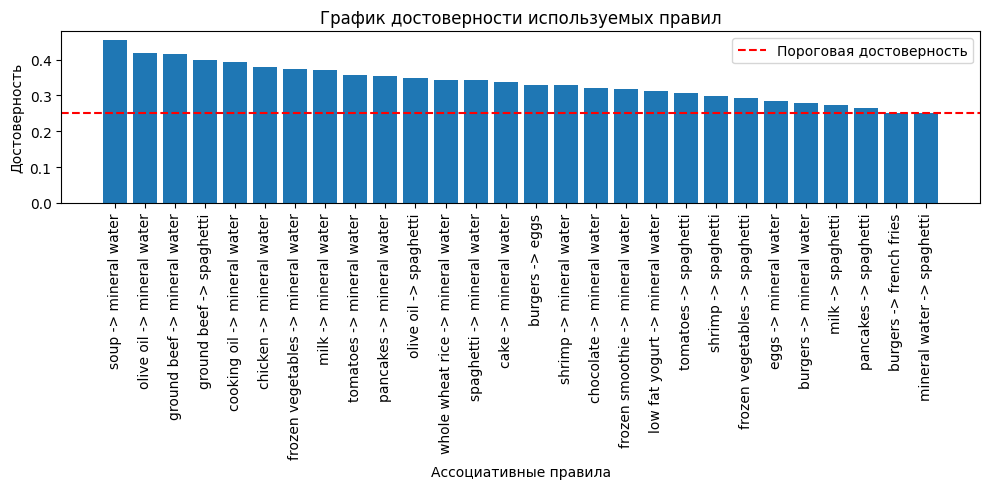

In [427]:
plt.figure(figsize=(10,5))
plt.bar(rules_labels, confidence)
plt.xlabel("Ассоциативные правила")
plt.ylabel("Достоверность")
plt.title("График достоверности используемых правил")
plt.axhline(y=0.25, linestyle='--', color='r', label='Пороговая достоверность')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

На гистограмме представлены значения достоверности для выявленных ассоциативных правил. Красная линия - выбранное пороговое значение достоверности.
Наибольшая достоверность (вероятность того, что при покупке предмета X возьмут и предмет Y) у правил soup->mineral water, olive oil->mineral water и ground beef->mineral water.  

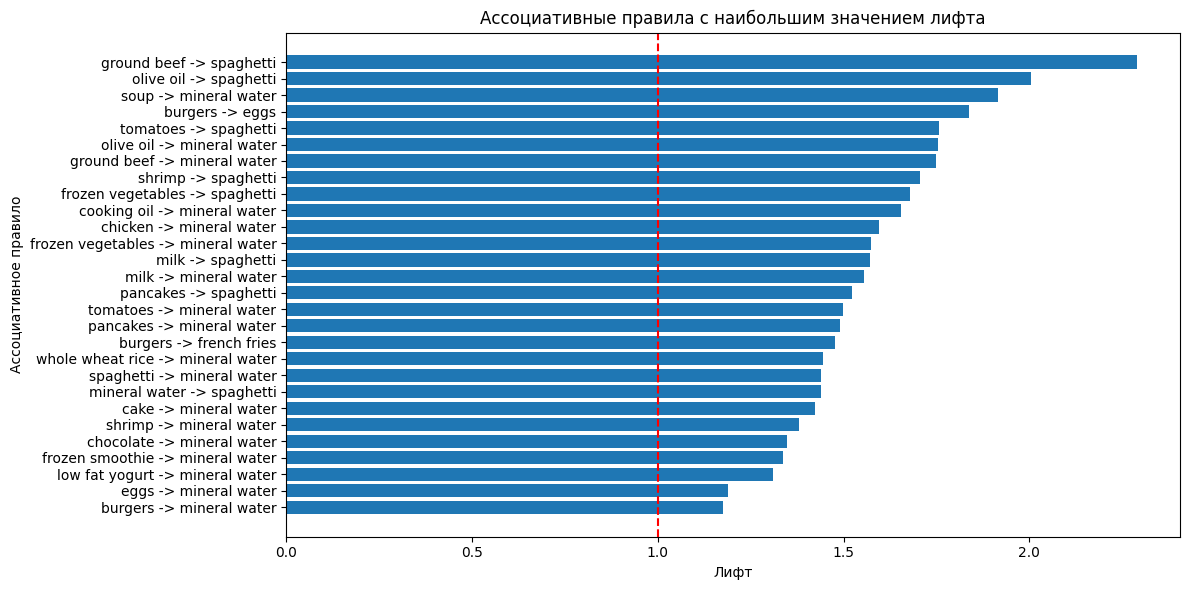

In [428]:
rules = rules.sort_values(by='lift', ascending=True)
products_1 = rules["antecedents"].tolist()
products_2 = rules["consequents"].tolist()
lift = rules["lift"].tolist()
rules_labels = [f"{product1} -> {product2}" for product1, product2 in zip(products_1, products_2)]

plt.figure(figsize=(12, 6))
plt.barh(rules_labels, lift)
plt.title('Ассоциативные правила с наибольшим значением лифта')
plt.ylabel('Ассоциативное правило')
plt.xlabel('Лифт')
plt.axvline(1, linestyle='--', color='r')
plt.tight_layout()
plt.show()

Полезные правила (с высоким лифтом) содержат действительную информацию, которая ранее была неизвестна, но имеет логичное объяснение. Такие правила могут быть использованы для принятия решений, приносящих выгоду.

Тривиальные правила содержат действительную и легко объяснимую информацию, которая уже известна. Такие правила, хотя и объяснимы, но не могут принести какой-либо пользы, так как отражают или известные законы в исследуемой области, или результаты прошлой деятельности. При анализе рыночных корзин в правилах с самой высокой поддержкой и достоверностью окажутся товары – лидеры продаж. Практическая ценность таких правил крайне низка.

Максимальное значение лифта у правила ground beef->spaghetti (2.29). Это очень сильная и очевидная связь, образующая правило, которое не дает ничего нового. Такими же правилами можно считать olive oil->spaghetti, tomatoes->spaghetti и тому подобные.
Наиболее полезные правила имеют достаточно среднее значения лифта (1.2 - 1.6). Правила с лифтом ближе к 1 являются тривиальными, то есть оба продукта часто покупаются, вне зависимости от связи между ними.

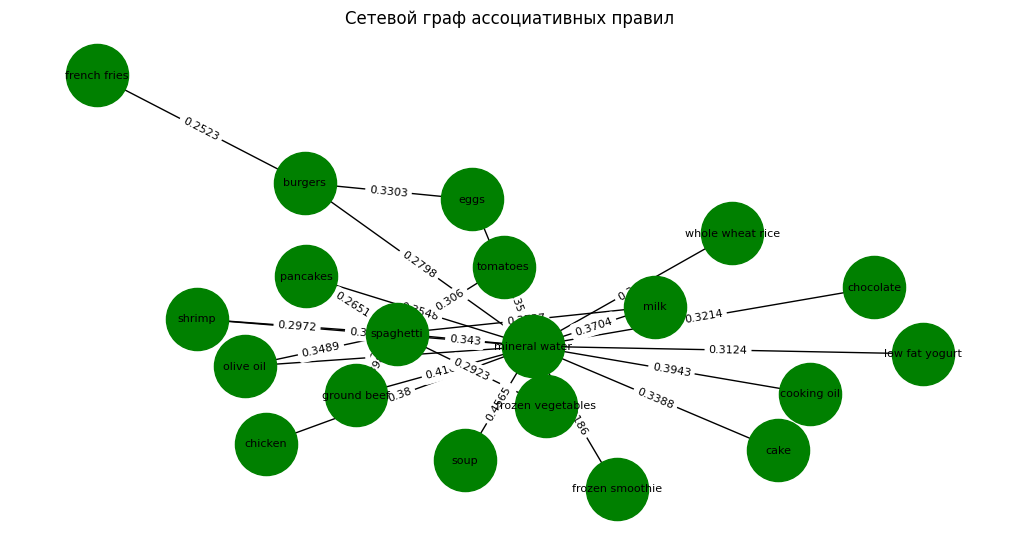

In [429]:
#Визуализация ассоциативных правил в виде графа
plt.figure(figsize=(10,5))
G = nx.Graph()
for product in rules["antecedents"]:
    G.add_node(product)
for product in rules["consequents"]:
    G.add_node(product)
for index, row in rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=np.round(row['confidence'], 4))
pos = nx.spring_layout(G, scale=2, k = 0.3)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='green', font_size=8)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title('Сетевой граф ассоциативных правил')
# plt.tight_layout()
plt.show()

Представление в виде сетевого графа состоит из узлов - продуктов, связанных ребрами-связями, маркированными значением достоверности данного правила. Расстояние между узлами так же зависит от достоверности. На построенном графе можно видеть группы вокруг mineral water и spaghetti - наиболее покупаемых и наболее встречаемых в правилах товаров. Группа вокруг spaghetti, например, образует ингредиенты для наиболее популярных блюд на основе этой пасты. 

#### Scatter-plot для просмотра одновременно поддержки, достоверности и лифта наиболее популярных правил

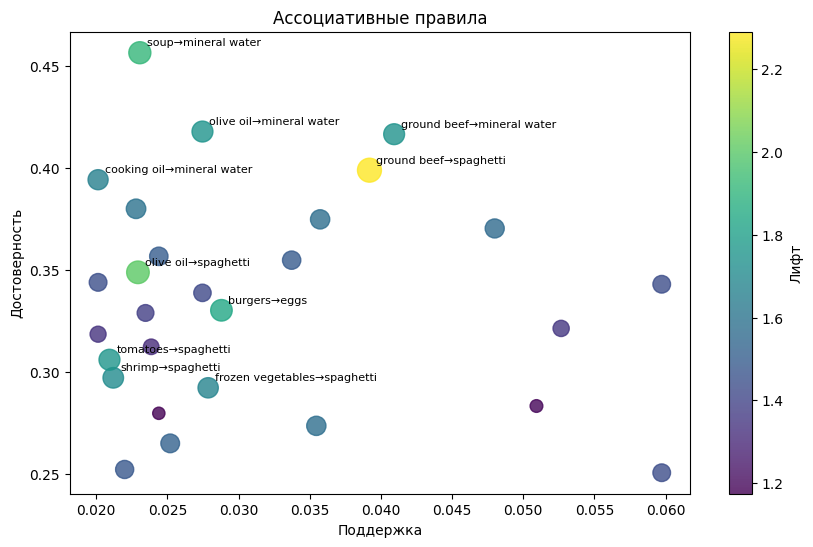

In [430]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    rules['support'], 
    rules['confidence'], 
    c=rules['lift'], 
    cmap='viridis', 
    s=528-528/rules['lift'],
    alpha=0.8
)

plt.colorbar(scatter, label='Лифт')
plt.xlabel('Поддержка')
plt.ylabel('Достоверность')
plt.title('Ассоциативные правила')

for i, rule in rules.nlargest(10, 'lift').iterrows():
    plt.annotate(
        f"{rule['antecedents']}→{rule['consequents']}", 
        (rule['support'], rule['confidence']),
        xytext=(5, 5), textcoords='offset points', fontsize=8
    )

plt.show()

Данное визуальное представление позволяет анализировать сразу несколько метрик для правил, наблюдать распределение их по поддержке (ось x) или достоверности (ось y), а также лифт такого правила (цвет и размер метки). 10 наиболее полезных правил по лифту подписаны на графике.

## Заключение

В ходе выполнения лабораторной работы был проведен анализ ассоциативных правил на основе датасета рыночных корзин с использованием алгоритмов Apriori и FP-Growth. После предварительной обработки данных и преобразования в транзакционный формат был выполнен анализ распределения длин транзакций и составлен перечень уникальных товаров.

Оба алгоритма успешно выявили наиболее популярные товары, среди которых лидируют mineral water, eggs и spaghetti. Наиболее значимым ассоциативным правилом оказалась связь spaghetti → mineral water с поддержкой 0.0597, достоверностью 0.343 и лифтом 1.44, что свидетельствует о статистически значимой взаимосвязи между этими продуктами.

Снижение порога поддержки увеличивает количество обнаруживаемых правил, но при этом возрастает доля слабых и менее надежных ассоциаций. Анализ выявил отсутствие правил с достоверностью ≥ 0.6 в данном датасете, а при одновременном использовании min_support ≥ 0.03 и min_confidence ≥ 0.5 ассоциативные правила не формируются.

Визуализация результатов в виде сетевого графа продемонстрировала структуру взаимосвязей между товарами, позволив выделить ассоциативные правила с общими чертами. Также был предложен альтернативный способ визуализации через scatter-plot метрик, что обеспечило многомерный анализ полученных результатов.